In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
 
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

url = "https://raw.githubusercontent.com/DuvanSGF/Coronavirus-Data_Science_Fundamentals/master/covid19.csv"

df = pd.read_csv(url, parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','contagiados'])
df.head()

fecha
2020-03-06    1
2020-03-09    2
2020-03-11    6
2020-03-12    4
2020-03-13    3
Name: contagiados, dtype: int64

In [4]:


# Por ejemplo, podemos ver de qué fechas tenemos datos con:
print(df.index.min())
print(df.index.max())



2020-03-06 00:00:00
2020-04-04 00:00:00


In [8]:


# Y ahora veamos cuantas muestras tenemos de cada mes
print(len(df['2020-03']))
print(len(df['2020-04']))



23
4


In [9]:


df.describe()



count     27.000000
mean      52.074074
std       45.506488
min        1.000000
25%       15.000000
50%       35.000000
75%       93.000000
max      159.000000
Name: contagiados, dtype: float64

In [10]:
# De hecho aprovechemos el tener indice de fechas con pandas y saquemos los promedios mensuales:
meses =df.resample('M').mean()
meses

fecha
2020-03-31     39.391304
2020-04-30    125.000000
Freq: M, Name: contagiados, dtype: float64

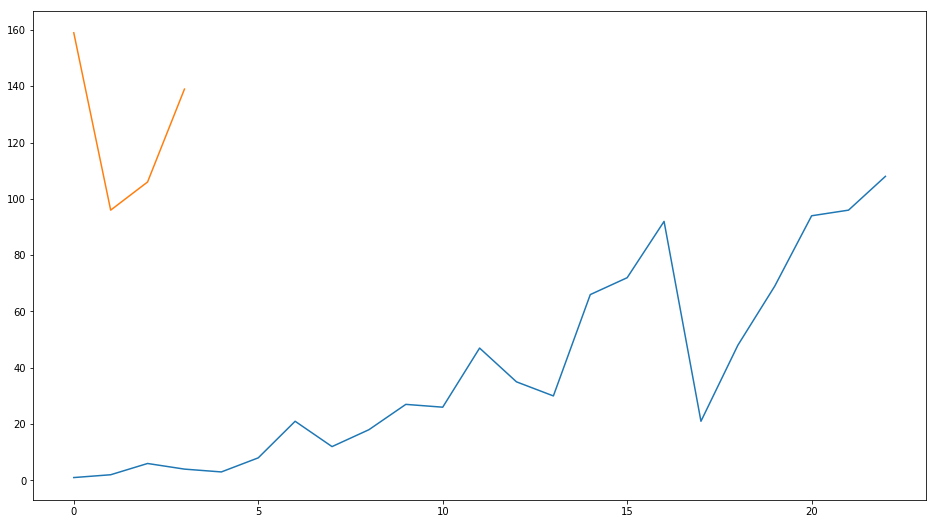

In [25]:
# Veamos la gráfica de contagios diarias (en personas) en marzo y abril
marzo = df['2020-03-06':'2020-03-31']
plt.plot(marzo.values)
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)

In [26]:
# Analizamos 7 dias y supondremos el 8
PASOS=7

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-1.000000,-0.987342,-0.936709,-0.962025,-0.974684,-0.911392,-0.746835,-0.860759
8,-0.987342,-0.936709,-0.962025,-0.974684,-0.911392,-0.746835,-0.860759,-0.784810
9,-0.936709,-0.962025,-0.974684,-0.911392,-0.746835,-0.860759,-0.784810,-0.670886
10,-0.962025,-0.974684,-0.911392,-0.746835,-0.860759,-0.784810,-0.670886,-0.683544
11,-0.974684,-0.911392,-0.746835,-0.860759,-0.784810,-0.670886,-0.683544,-0.417722


In [44]:
# significa algo así como «27 entradas con vectores de 1×7».
# split into train and test sets
values = reframed.values
n_train_days = 23+4 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(10, 1, 6) (10,) (10, 1, 6) (10,)


In [45]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [47]:
ultimosDias = df['2020-03-06':'2020-04-30']
ultimosDias

fecha
2020-03-06      1
2020-03-09      2
2020-03-11      6
2020-03-12      4
2020-03-13      3
2020-03-14      8
2020-03-15     21
2020-03-16     12
2020-03-17     18
2020-03-18     27
2020-03-19     26
2020-03-20     47
2020-03-21     35
2020-03-22     30
2020-03-23     66
2020-03-24     72
2020-03-25     92
2020-03-26     21
2020-03-27     48
2020-03-28     69
2020-03-29     94
2020-03-30     96
2020-03-31    108
2020-04-01    159
2020-04-02     96
2020-04-03    106
2020-04-04    139
Name: contagiados, dtype: int64

In [48]:


values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)



,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-1.000000,-0.987342,-0.936709,-0.962025,-0.974684,-0.911392,-0.746835
8,-0.987342,-0.936709,-0.962025,-0.974684,-0.911392,-0.746835,-0.860759
9,-0.936709,-0.962025,-0.974684,-0.911392,-0.746835,-0.860759,-0.784810
10,-0.962025,-0.974684,-0.911392,-0.746835,-0.860759,-0.784810,-0.670886
11,-0.974684,-0.911392,-0.746835,-0.860759,-0.784810,-0.670886,-0.683544
12,-0.911392,-0.746835,-0.860759,-0.784810,-0.670886,-0.683544,-0.417722
13,-0.746835,-0.860759,-0.784810,-0.670886,-0.683544,-0.417722,-0.569620


In [49]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[-0.7468355 , -0.8607595 , -0.7848101 , -0.67088604,
         -0.6835443 , -0.4177215 , -0.56962025]],

       [[-0.8607595 , -0.7848101 , -0.67088604, -0.6835443 ,
         -0.4177215 , -0.56962025, -0.6329114 ]],

       [[-0.7848101 , -0.67088604, -0.6835443 , -0.4177215 ,
         -0.56962025, -0.6329114 , -0.17721516]],

       [[-0.67088604, -0.6835443 , -0.4177215 , -0.56962025,
         -0.6329114 , -0.17721516, -0.10126579]],

       [[-0.6835443 , -0.4177215 , -0.56962025, -0.6329114 ,
         -0.17721516, -0.10126579,  0.15189874]],

       [[-0.4177215 , -0.56962025, -0.6329114 , -0.17721516,
         -0.10126579,  0.15189874, -0.7468355 ]],

       [[-0.56962025, -0.6329114 , -0.17721516, -0.10126579,
          0.15189874, -0.7468355 , -0.40506327]],

       [[-0.6329114 , -0.17721516, -0.10126579,  0.15189874,
         -0.7468355 , -0.40506327, -0.1392405 ]],

       [[-0.17721516, -0.10126579,  0.15189874, -0.7468355 ,
         -0.40506327, -0.1392405 ,  0.17721

In [50]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.7468355  -0.8607595  -0.7848101  -0.67088604 -0.6835443
   -0.4177215  -0.56962025]]

 [[-0.8607595  -0.7848101  -0.67088604 -0.6835443  -0.4177215
   -0.56962025 -0.6329114 ]]

 [[-0.7848101  -0.67088604 -0.6835443  -0.4177215  -0.56962025
   -0.6329114  -0.17721516]]

 [[-0.67088604 -0.6835443  -0.4177215  -0.56962025 -0.6329114
   -0.17721516 -0.10126579]]

 [[-0.6835443  -0.4177215  -0.56962025 -0.6329114  -0.17721516
   -0.10126579  0.15189874]]

 [[-0.4177215  -0.56962025 -0.6329114  -0.17721516 -0.10126579
    0.15189874 -0.7468355 ]]

 [[-0.56962025 -0.6329114  -0.17721516 -0.10126579  0.15189874
   -0.7468355  -0.40506327]]

 [[-0.6329114  -0.17721516 -0.10126579  0.15189874 -0.7468355
   -0.40506327 -0.1392405 ]]

 [[-0.17721516 -0.10126579  0.15189874 -0.7468355  -0.40506327
   -0.1392405   0.17721522]]

 [[-0.10126579  0.15189874 -0.7468355  -0.40506327 -0.1392405
    0.17721522  0.2025317 ]]

 [[ 0.15189874 -0.7468355  -0.40506327 -0.1392405   0.17721522
    0.202531

In [51]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[93.51948285],
       [96.65612663],
       [80.70081209],
       [79.75381587],
       [59.02012122],
       [50.44829152],
       [71.79713102]])

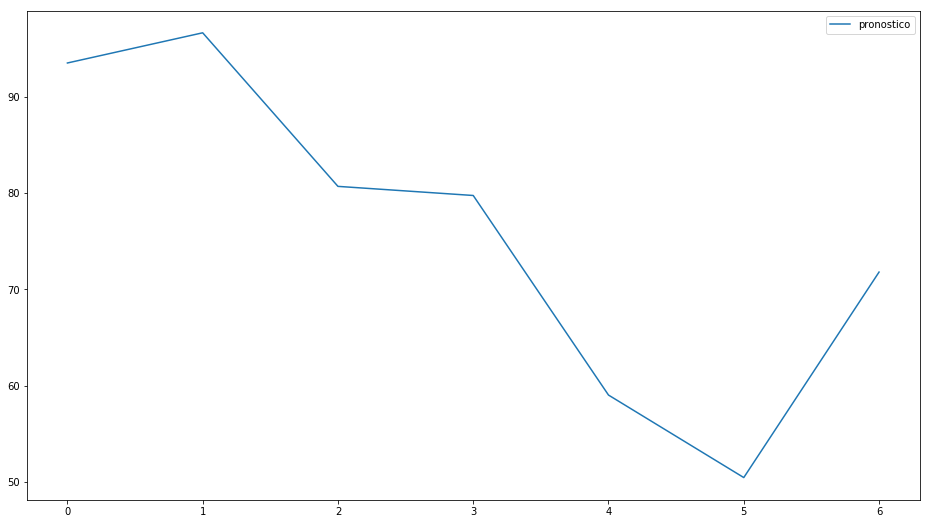

In [52]:
prediccion2SemanaAbril = pd.DataFrame(inverted)
prediccion2SemanaAbril.columns = ['pronostico']
prediccion2SemanaAbril.plot()
prediccion2SemanaAbril.to_csv('pronostico.csv')